In [1]:
import os
import os.path as op
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import sklearn
import patsy
from scipy.optimize import minimize
from sklearn import linear_model
import multiprocessing
import random
%matplotlib inline

In [14]:
#Read in data
data_dir = os.path.abspath('../')
all_rts = pd.read_csv(data_dir + '/all_rts.csv', index_col =0)
exp_order = pd.read_csv(data_dir + '/exp_order.csv', index_col =0)
exp_order = exp_order.set_index(['exp','run'])

subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))

#some experiment variables
order_dict_ser = {'c_plus':6, 'b_plus':2, 'b_minus':3, 'c_minus':5} #coding for trial order vector
order_dict_sim = {'c_plus':4, 'b_plus':1, 'b_minus':2, 'c_minus':3}
order_dict_exp = {'ser': order_dict_ser, 'sim':order_dict_sim}

order_dict_reverse_exp = {}
for exp in ['sim','ser']:
    order_dict = order_dict_exp[exp]
    order_dict_reverse = {val:key for key,val in zip(order_dict.keys(),order_dict.values())}
    order_dict_reverse[10] = None
    if exp == 'ser':
        order_dict_reverse[1] = None
        order_dict_reverse[4] = None
    order_dict_reverse_exp[exp] = order_dict_reverse.copy()

In [15]:
### process the RTs a bit (remove trial types 1, 4, and 10 (see below) and mean center)
sim_rts = all_rts[all_rts['exp']=='sim']
sim_rts = sim_rts[sim_rts['order'] != 10] #ITI

rt_dict_exp = {'sim':sim_rts}

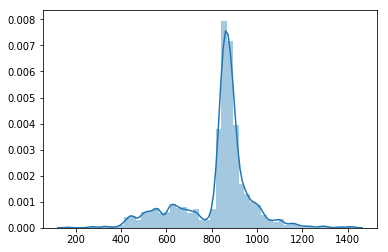

In [16]:
a = sim_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);

# Compare models using Bayesian RFX

In [53]:
def calc_aicc(ll,n_params,n_obs):
    return -2*ll + 2*n_params + (2*n_params * (n_params+1))/(n_obs*1.0 - n_params -1)

In [3]:
from pymatbridge import Matlab
mlab = Matlab()
%load_ext pymatbridge


/home/iballard/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-5379e930-ebfa-4740-83db-d8f33aafada8
Send 'exit' command to kill the server
...........MATLAB started and connected!


### Now define each RL model

In [65]:
#write to text file
path = op.abspath('../rt_fitting/evidence/')
for m in set(df.index):

    if m in ['leak_RL']:
        n_params = 4
    elif m == 'null_RL':
        n_params = 1
    else:
        n_params = 3
        
    aic = []
    bic = []
    for sub,ll in zip(df.loc[m,'sub'].values,
                      df.loc[m,'ll'].values):
        
        n_obs =  np.loadtxt(op.abspath('../rt_fitting/n_obs/') + '/' + exp + '_' + sub + '_nobs')

        aic.append(calc_aicc(ll,n_params,n_obs))
        bic.append(calc_bic(ll,n_params,n_obs))

    np.savetxt(op.join(path, m + '_aic'),aic)
    np.savetxt(op.join(path, m + '_bic'),bic)


In [4]:
%%matlab -o pxp_a
path = '/home/iballard/Dropbox/fd/rt_fitting/evidence/';
ic = '_aic';
brain = textread([path,'brain_RL',ic]);
null = textread([path,'null_RL',ic]);
standard = textread([path,'standard_RL',ic]);
single = textread([path,'single_item_state',ic]);
dumb = textread([path,'dumb_RL',ic]);
leak = textread([path,'leak_RL',ic]);
lc = [leak, standard, single, null];
lc = lc*-1;
[alpha,exp_r,xp,pxp_a,bor] = spm_BMS(lc);

In [5]:
# model = ['std','single','leak','null']

# xp_df = pd.DataFrame({'model':model*2,
#                       'Protected Exceedance Probability':list(pxp_b[0]) + list(pxp_a[0]),
#                      'metric':['bic']*len(model) + ['aic']*len(model) })
# ax = sns.barplot(x = 'model', y = 'Protected Exceedance Probability',
#             hue = 'metric',data = xp_df,)
# plt.title('RFX Bayesian Model Comparison')
# plt.ylabel('Protected Exceedance Probability')
# plt.xlabel('')
# ax.set_ylim([0,1])
# # plt.savefig('../figures/model_fit_full.png',dpi=600)

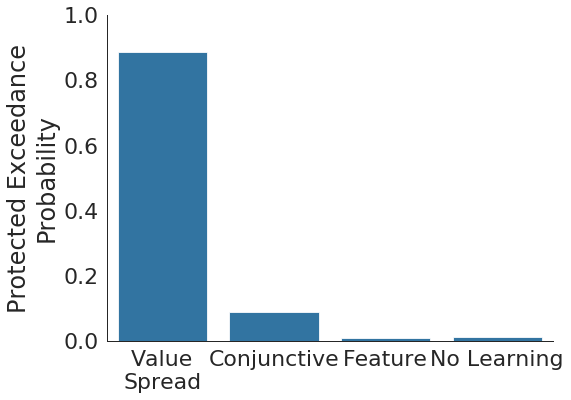

In [23]:
model = ['Value\nSpread', 'Conjunctive','Feature','No Learning']
sns.set_context('paper',font_scale = 2.5)
sns.set_style("white")
plt.figure(figsize=(8,6))

xp_df = pd.DataFrame({'model':model,
                      'Protected Exceedance Probability': list(pxp_a[0]),
                     'metric':['aic']*len(model)})
ax = sns.barplot(x = 'model', y = 'Protected Exceedance Probability',
            hue = 'metric',data = xp_df)
ax.get_legend().set_visible(False)


# plt.title('RFX Bayesian Model Comparison')
plt.ylabel('Protected Exceedance\nProbability')
plt.xlabel('')
ax.set_ylim([0,1])
sns.despine()
plt.savefig('/home/iballard/Dropbox/fd/figs/revision/bayes_model_comparison_std.png', 
            dpi = 600,
           bbox_inches = 'tight')

In [7]:
pxp_a

array([[0.88822841, 0.08855868, 0.01108115, 0.01213176]])